# assignment_1a question 3

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 3: Optimal Hidden Neurons](#optimal_hidden_neurons)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing Hidden Neurons](#eyeballing_hidden_neurons)
    * [Try Test Set](#try_test_set)
* [Conclusion](#conclusion)    

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import time

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

cv_5fold = KFold(n_splits=5, random_state=seed)
cv_5fold.get_n_splits(X_train)

# data objects
histories = {} 

C:\Users\user\anaconda3\envs\cz4042_env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [4]:
# filename like 'data/histories_q1.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [5]:
# filename like 'data/histories_q0.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [6]:
def plot_history_object(histories, model_name, history_object, plot_val=True):    
    plt.plot(histories[model_name][history_object], label='train_'+history_object)
    
    if plot_val:
        plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

### TestCallback()

In [7]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy, sparse_categorical_crossentropy = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['accuracy'].append(accuracy)
        histories_test['test_values']['loss'].append(loss)
        histories_test['test_values']['sparse_categorical_crossentropy'].append(sparse_categorical_crossentropy)

### TimeHistory()

In [8]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Question 3: Optimal Hidden Neurons  <a name="optimal_hidden_neurons"></a>
[Back to top](#toc)

<i>Find the optimal number of hidden neurons for the 3-layer network designed in part (2).

* a) Plot the cross-validation accuracies against the number of epochs for different number of hidden-layer neurons. Limit the search space of number of neurons to {5,10,15,20,25}.
* b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection.
* c) Plot the train and test accuracies against epochs with the optimal number of neurons. </i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [14]:
num_neurons = [5,10,15,20,25]
num_classes = 3

weight_decay_parameter = 10e-6
regularization = keras.regularizers.l2(weight_decay_parameter)

learning_rate= 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy', keras.metrics.SparseCategoricalCrossentropy(from_logits=False)]

validation_split = 0.3
epochs = 450 # from assignment_1a_q1
batch_size = 16 # from assignment_1a_q2

callbacks = [TqdmCallback(verbose=1)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [15]:
def create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [16]:
def fit_model_kfold(X_train, Y_train, X_val, Y_val, model_name, model, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_data=(X_val, Y_val),
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

In [18]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=0.3,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [19]:
for num_neuron in num_neurons:    
    for index, (train_fold_index, val_fold_index) in enumerate(cv_5fold.split(X_train)):
        X_train_fold = X_train[train_fold_index]
        X_val_fold = X_train[val_fold_index]
        Y_train_fold = Y_train[train_fold_index]
        Y_val_fold = Y_train[val_fold_index]

        model = create_model(num_neuron, num_classes, regularization, optimizer, loss, metrics)
        model_name = "num_neuron_" + str(num_neuron) + "_fold_" + str(index+1)
        
        # create a new time_callback for every run
        callbacks = [TqdmCallback(verbose=1)]
        
        model_num_neuron_train, histories[model_name] = fit_model_kfold(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, model_name, model, epochs, batch_size, callbacks)

Model created


Training  num_neuron_5_fold_1


Model created


Training  num_neuron_5_fold_2

Model created


Training  num_neuron_5_fold_3

Model created


Training  num_neuron_5_fold_4

Model created


Training  num_neuron_5_fold_5

Model created


Training  num_neuron_10_fold_1

Model created


Training  num_neuron_10_fold_2

Model created


Training  num_neuron_10_fold_3

Model created


Training  num_neuron_10_fold_4

Model created


Training  num_neuron_10_fold_5

Model created


Training  num_neuron_15_fold_1

Model created


Training  num_neuron_15_fold_2

Model created


Training  num_neuron_15_fold_3

Model created


Training  num_neuron_15_fold_4

Model created


Training  num_neuron_15_fold_5

Model created


Training  num_neuron_20_fold_1

Model created


Training  num_neuron_20_fold_2

Model created


Training  num_neuron_20_fold_3

Model created


Training  num_neuron_20_fold_4

Model created


Training  num_neuron_20_fold_5

Model created


Training  num_neuron_25_fold_1

Model created


Training  num_neuron_25_fold_2

Model created


Training  num_neuron_25_fold_3

Model created


Training  num_neuron_25_fold_4

Model created


Training  num_neuron_25_fold_5



### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [20]:
histories_saver(histories, "data/q3_histories.json")

histories = histories_loader("data/q3_histories.json")

Histories saved
Histories loaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  num_neuron_5_fold_1


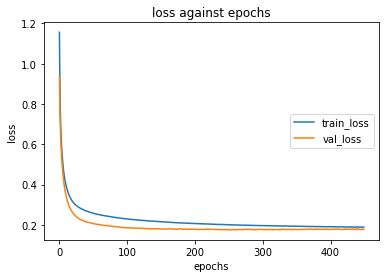

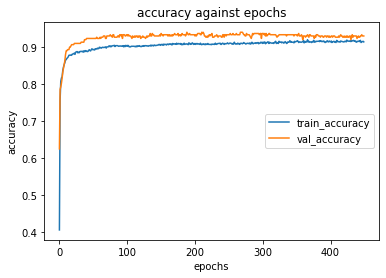

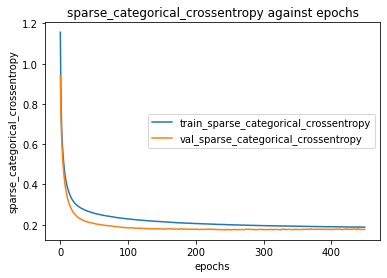

Model:  num_neuron_5_fold_2


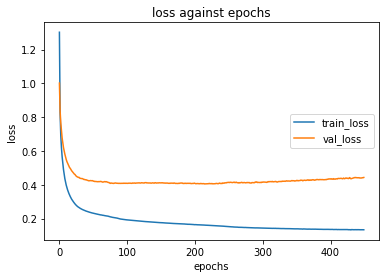

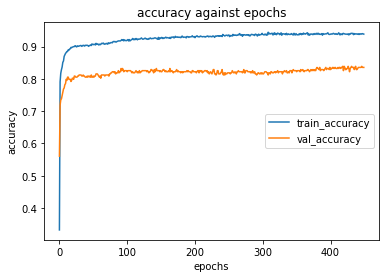

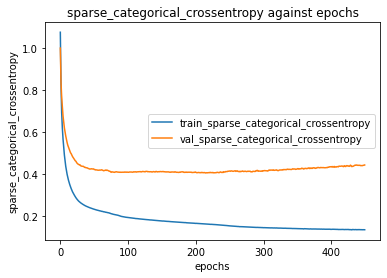

Model:  num_neuron_5_fold_3


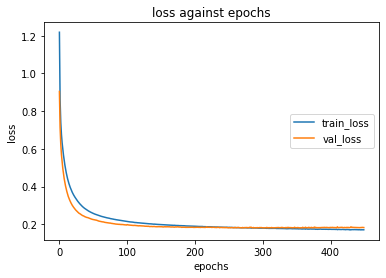

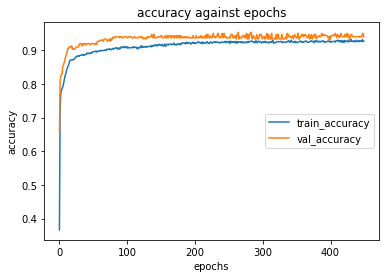

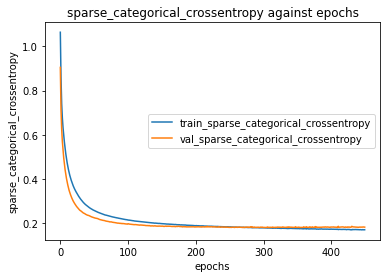

Model:  num_neuron_5_fold_4


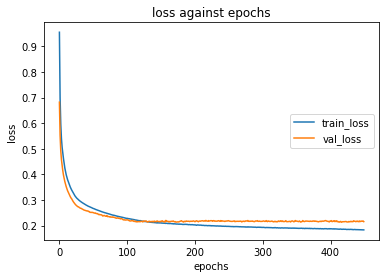

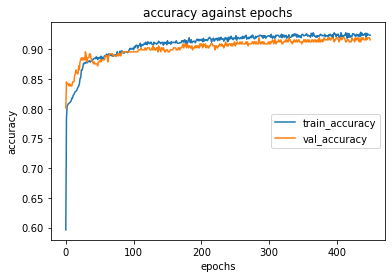

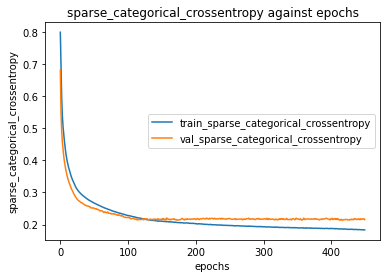

Model:  num_neuron_5_fold_5


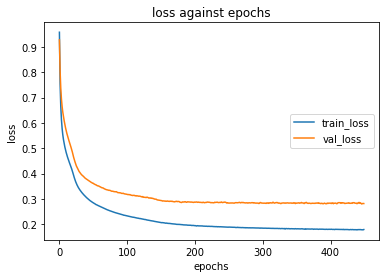

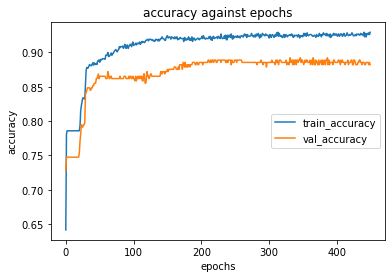

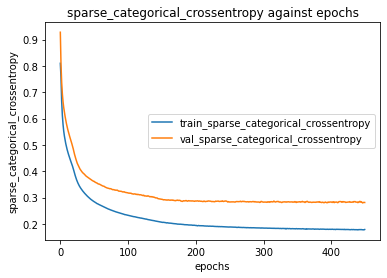

Model:  num_neuron_10_fold_1


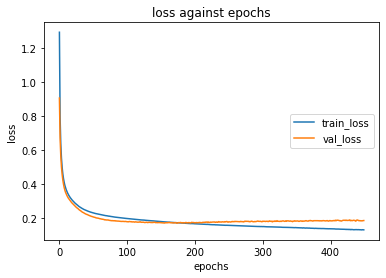

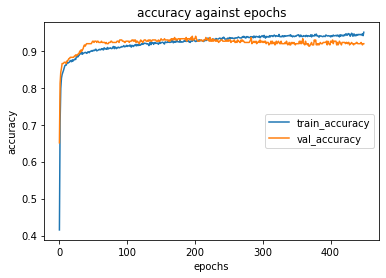

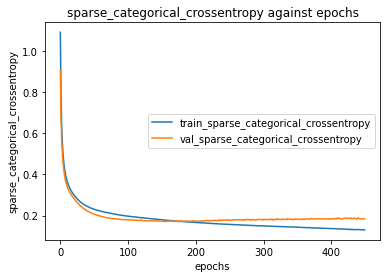

Model:  num_neuron_10_fold_2


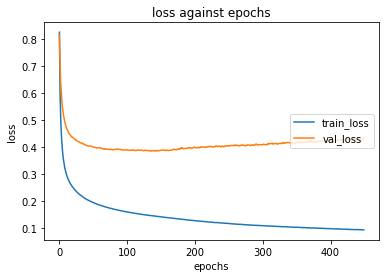

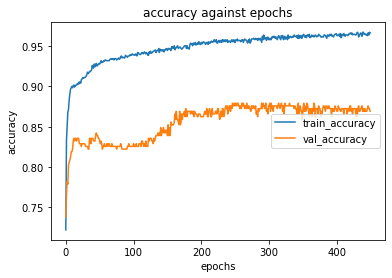

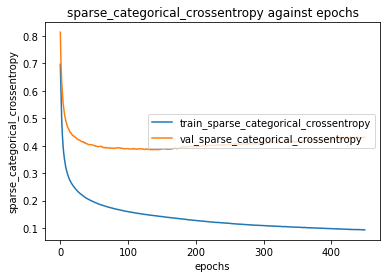

Model:  num_neuron_10_fold_3


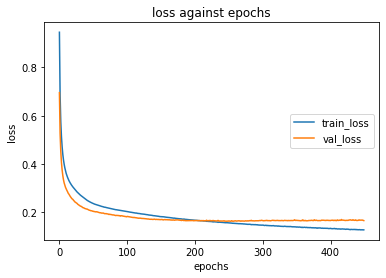

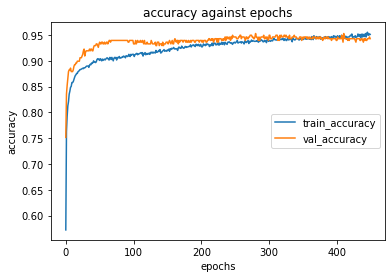

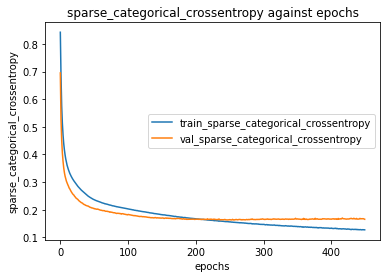

Model:  num_neuron_10_fold_4


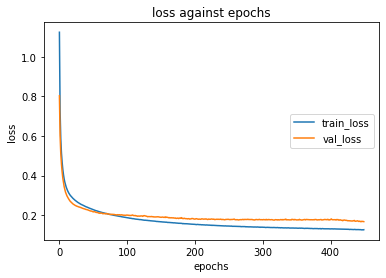

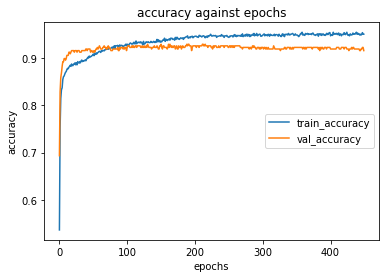

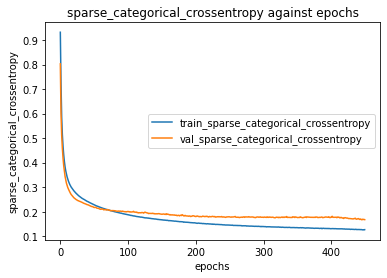

Model:  num_neuron_10_fold_5


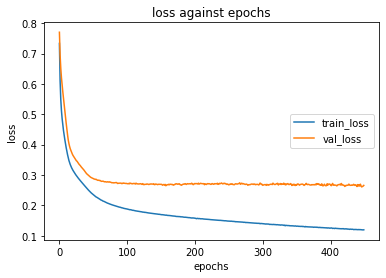

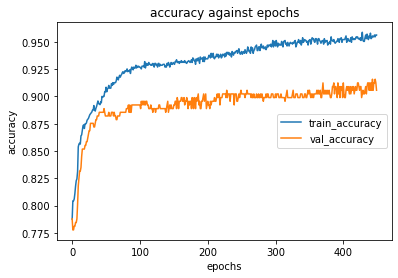

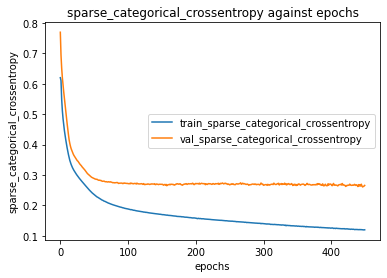

Model:  num_neuron_15_fold_1


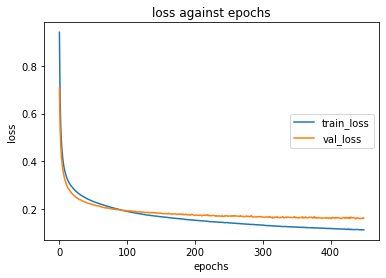

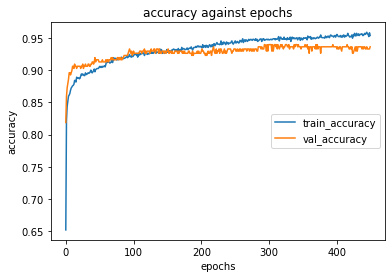

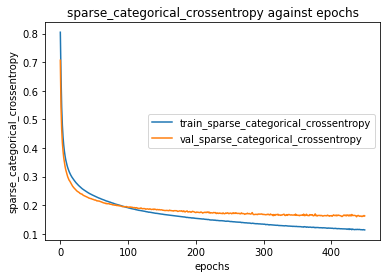

Model:  num_neuron_15_fold_2


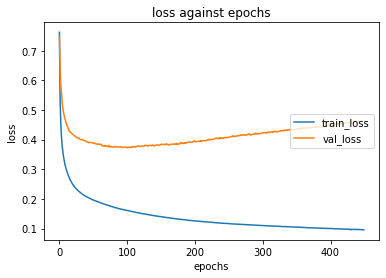

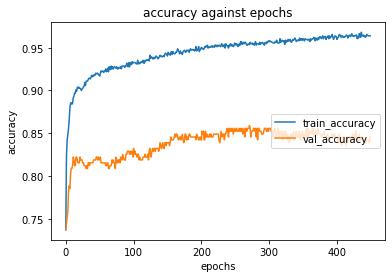

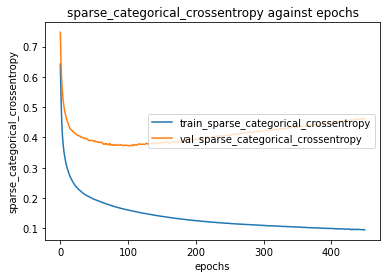

Model:  num_neuron_15_fold_3


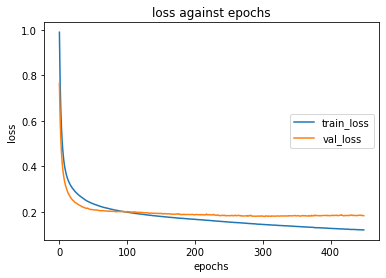

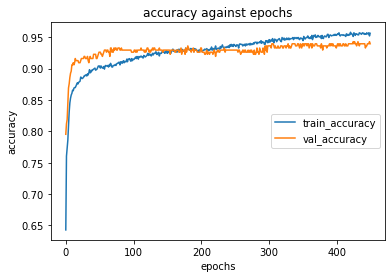

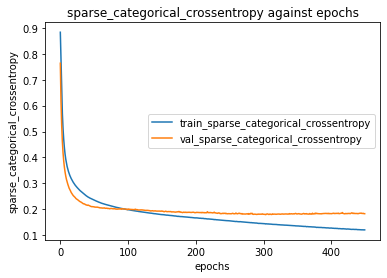

Model:  num_neuron_15_fold_4


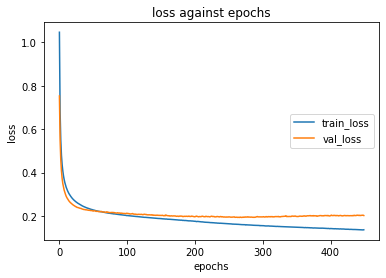

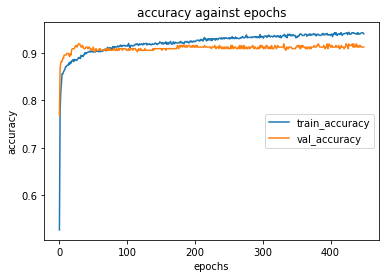

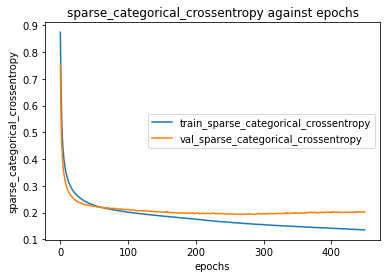

Model:  num_neuron_15_fold_5


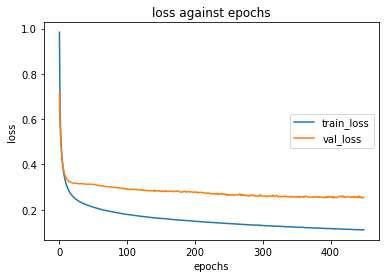

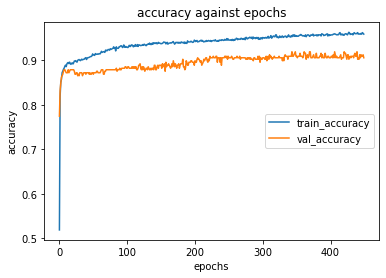

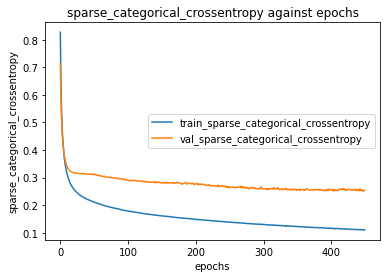

Model:  num_neuron_20_fold_1


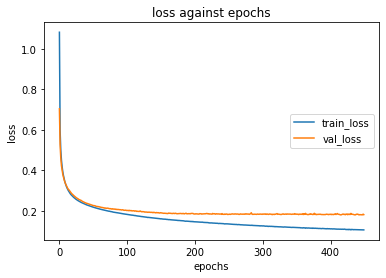

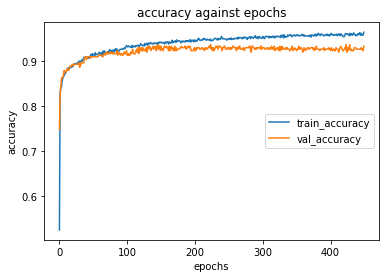

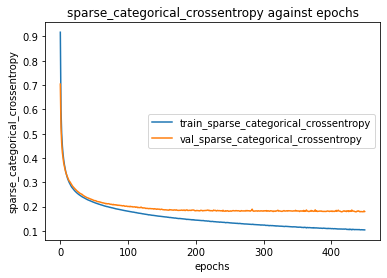

Model:  num_neuron_20_fold_2


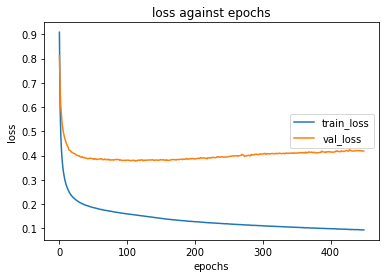

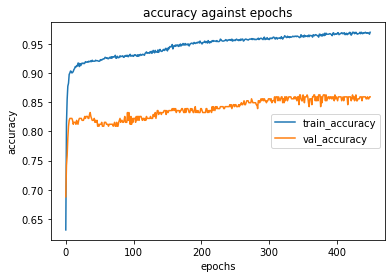

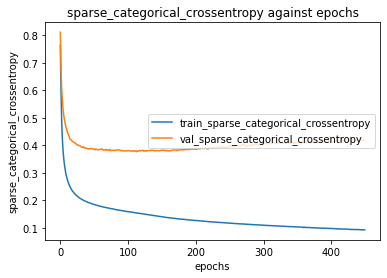

Model:  num_neuron_20_fold_3


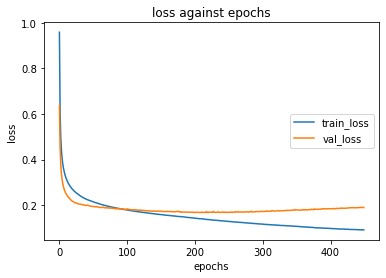

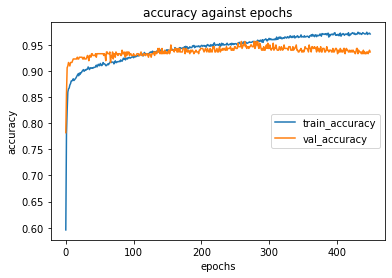

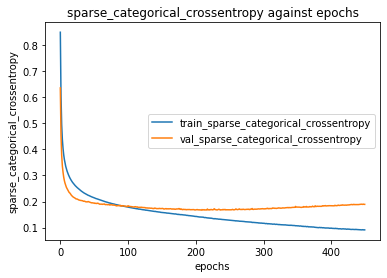

Model:  num_neuron_20_fold_4


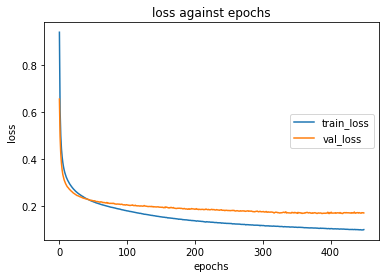

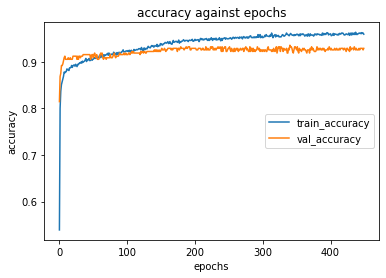

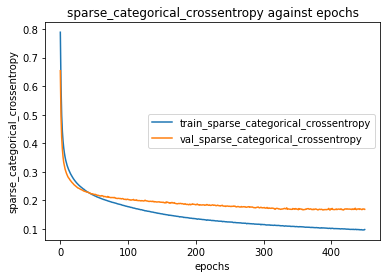

Model:  num_neuron_20_fold_5


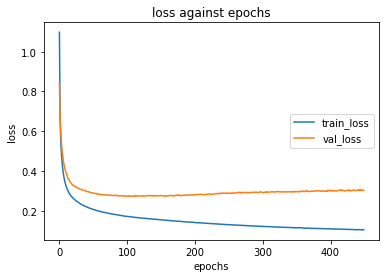

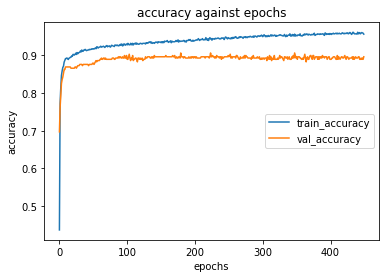

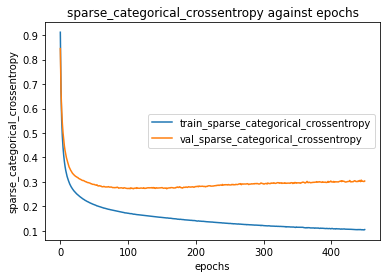

Model:  num_neuron_25_fold_1


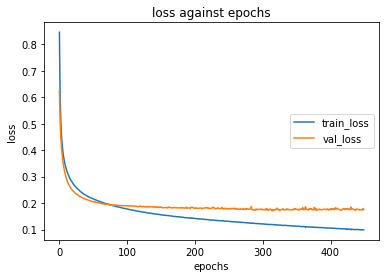

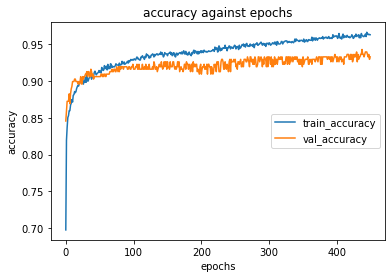

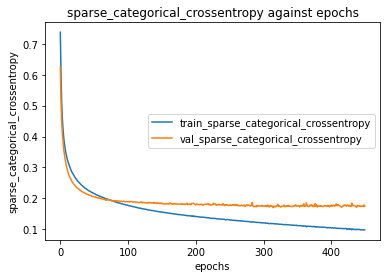

Model:  num_neuron_25_fold_2


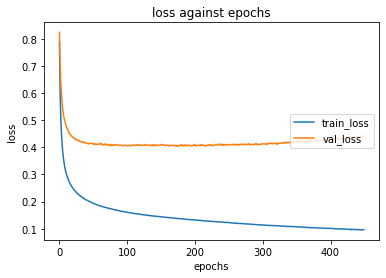

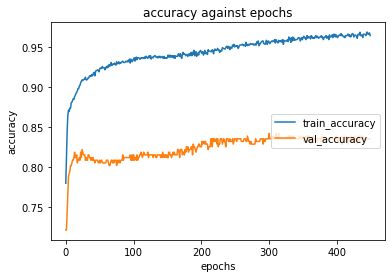

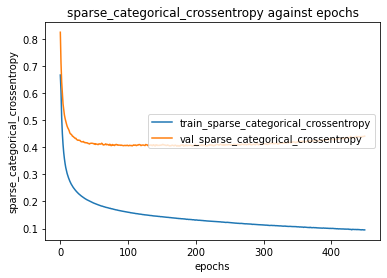

Model:  num_neuron_25_fold_3


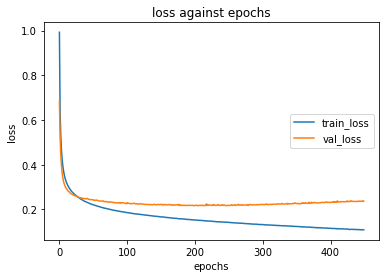

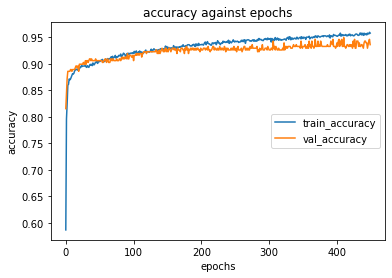

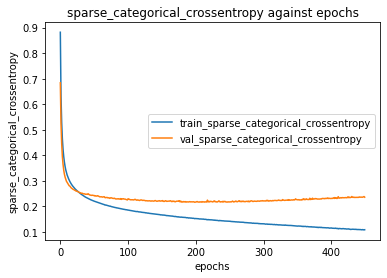

Model:  num_neuron_25_fold_4


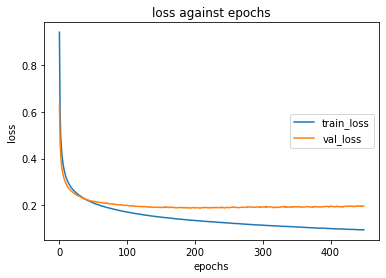

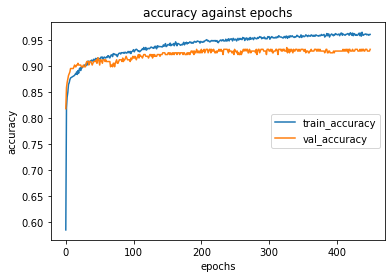

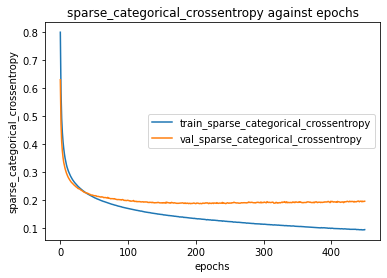

Model:  num_neuron_25_fold_5


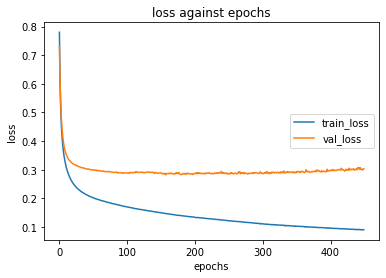

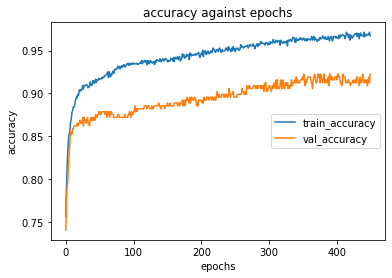

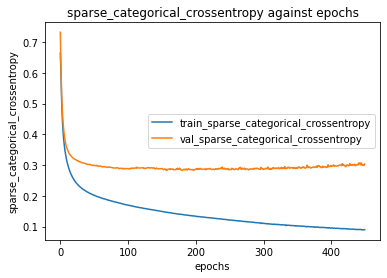

In [21]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
        plot_history_object(histories, model_name, history_object)

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

We need to find out the average performance metric across all the folds

> ### a) Plot the cross-validation accuracies against the number of epochs for different number of hidden-layer neurons. Limit the search space of number of neurons to {5,10,15,20,25}.

##### Average metrics per epoch

In [22]:
ave_loss = []
ave_val_loss = []
ave_accuracy = []
ave_val_accuracy = []
ave_ce = []
ave_val_ce = []

for num_neuron in num_neurons:
    nn_loss = []
    nn_val_loss = []
    nn_accuracy = []
    nn_val_accuracy = []
    nn_ce = []
    nn_val_ce = []
    
    for index in range(5):
        history = histories['num_neuron_' + str(num_neuron) + '_fold_' + str(index+1)]

        nn_loss.append(np.array(history['loss']))
        nn_val_loss.append(np.array(history['val_loss']))
        nn_accuracy.append(np.array(history['accuracy']))
        nn_val_accuracy.append(np.array(history['val_accuracy']))
        nn_ce.append(np.array(history['sparse_categorical_crossentropy']))
        nn_val_ce.append(np.array(history['val_sparse_categorical_crossentropy']))
        
    ave_loss.append(np.mean(nn_loss, axis=0))
    ave_val_loss.append(np.mean(nn_val_loss, axis=0))
    ave_accuracy.append(np.mean(nn_accuracy, axis=0))
    ave_val_accuracy.append(np.mean(nn_val_accuracy, axis=0))
    ave_ce.append(np.mean(nn_ce, axis=0))
    ave_val_ce.append(np.mean(nn_val_ce, axis=0))

print('Generated averages')

Generated averages


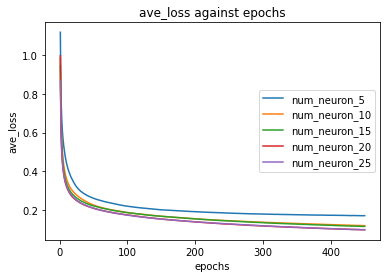

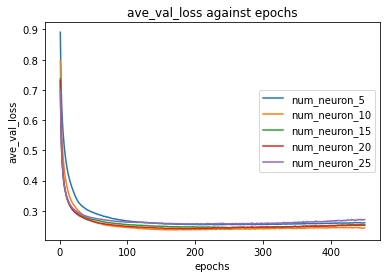

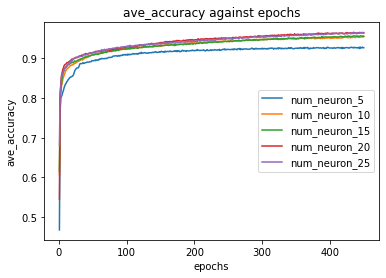

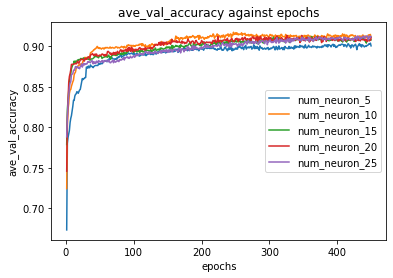

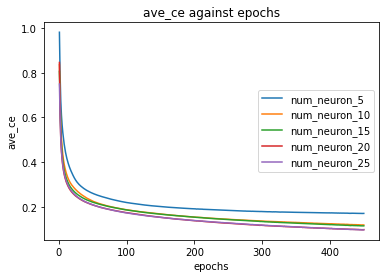

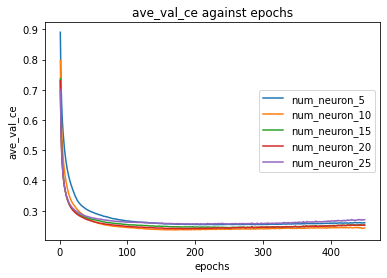

In [24]:
epochs_label = np.arange(1, epochs+1)

performance_metrics = [ave_loss, ave_val_loss, ave_accuracy, ave_val_accuracy, ave_ce, ave_val_ce]
performance_metrics_mapping = ['ave_loss', 'ave_val_loss', 'ave_accuracy', 'ave_val_accuracy', 'ave_ce', 'ave_val_ce']

for index, performance_metric in enumerate(performance_metrics):
    name = performance_metrics_mapping[index]
    
    for i in range(5):
        plt.plot(epochs_label, performance_metric[i], label='num_neuron_'+str(num_neurons[i]))
        plt.title(name + " against epochs")
        plt.ylabel(name)
        plt.xlabel("epochs")
        plt.legend(loc="center right")
    plt.show()

### Eyeballing Hidden Neurons <a name="eyeballing_hidden_neurons"></a> 
[Back to top](#toc)

We can see from averaging the validation set values, that ```num_neuron = 10, 15, 20``` all have rather good performance

However, we can see that ```num_neuron=20``` always appears to be the top two best model in every performance metric

Let's take a slightly more mathematical approach and consider the incremental time gains gotten from the incremental gains in performance, using the best results of ```num_neuron = 20``` as the baseline since it appears to be the best performer

In [26]:
incremental_ave_accuracy = np.array(ave_accuracy).T.copy()
incremental_ave_val_accuracy = np.array(ave_val_accuracy).T.copy()
incremental_ave_loss = np.array(ave_loss).T.copy()
incremental_ave_val_loss = np.array(ave_val_loss).T.copy()
incremental_ave_ce = np.array(ave_ce).T.copy()
incremental_ave_val_ce = np.array(ave_val_ce).T.copy()

In [28]:
incremental_metrics = [incremental_ave_accuracy, incremental_ave_val_accuracy, incremental_ave_loss, incremental_ave_val_loss, incremental_ave_ce, incremental_ave_val_ce]
incremental_metrics_mapping = ['incremental_ave_accuracy', 'incremental_ave_val_accuracy', 'incremental_ave_loss', 'incremental_ave_val_loss', 'incremental_ave_ce', 'incremental_ave_val_ce']

baseline_column = 'nn=20'

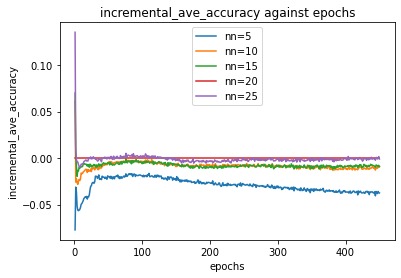

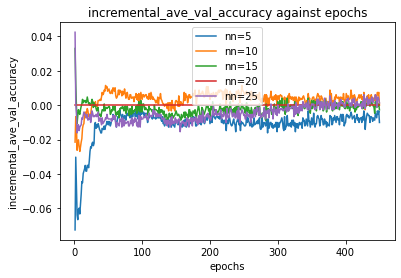

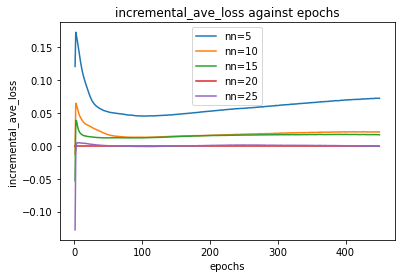

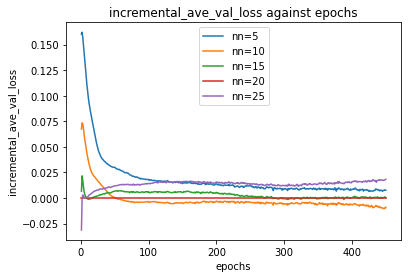

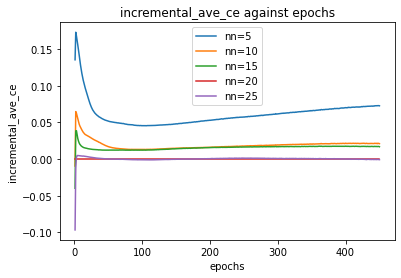

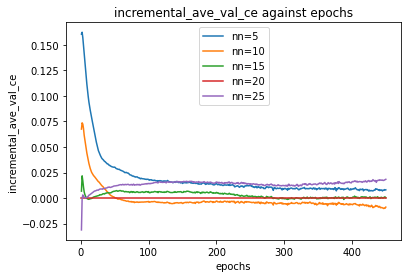

In [32]:
for index, incremental_metric in enumerate(incremental_metrics):
    df_incremental_metric = pd.DataFrame(incremental_metric, columns =['nn=5', 'nn=10', 'nn=15', 'nn=20', 'nn=25']) 
    df_incremental_metric_baseline = pd.DataFrame(df_incremental_metric[baseline_column], columns=[baseline_column])
    
    for column in df_incremental_metric.columns:
        df_incremental_metric[column] = df_incremental_metric[column] - df_incremental_metric_baseline[baseline_column]

    for column in df_incremental_metric.columns:
        plt.plot(epochs_label, df_incremental_metric[column], label=column)
        plt.title(incremental_metrics_mapping[index] + ' against epochs')
        plt.ylabel(incremental_metrics_mapping[index])
        plt.xlabel("epochs")
        plt.legend(loc="upper center")    
    plt.show()

> ### b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection. 

> ```num_neurons=10``` is the more superior configuration
 
After plotting the incremental changes, we can see that ```num_neurons=10``` has lower validation losses and higher validation accuracy than ```num_neurons=20```

<!-- > ```batch_size=16``` is a good middle ground, and stable, and fast enough

It straddles the line well between incremental accuracy gained against larger batch sizes, and incremental fluctuations in losses gained against smaller batch sizes 

It also has a big advantage in time/epoch over smaller batch sizes, and comparable against larger batch sizes
 -->

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use ```num_neuron=10``` to check the performance of the model on the test set

In [37]:
# the optimized parameter and custome callback
num_neuron = 10
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'accuracy': [],
        'sparse_categorical_crossentropy': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final = {}

In [38]:
model = create_model(num_neuron, num_classes, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_convergence_test, histories_final[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final, "data/q3_histories_final.json")
histories_final = histories_loader("data/q3_histories_final.json")

histories_final['test_values'] = histories_test['test_values']

histories_saver(histories_final, "data/q3_histories_final.json", already_json=True)
histories_final = histories_loader("data/q3_histories_final.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


> ### c) Plot the train and test accuracies against epochs for the optimal batch size. 

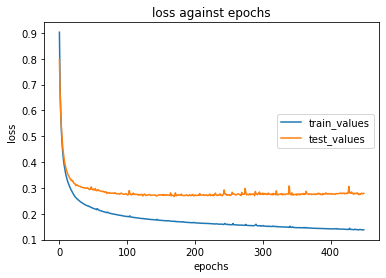

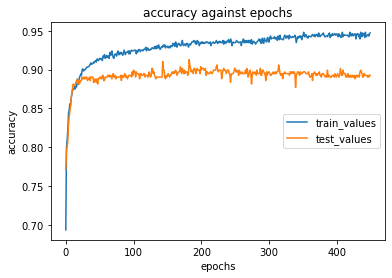

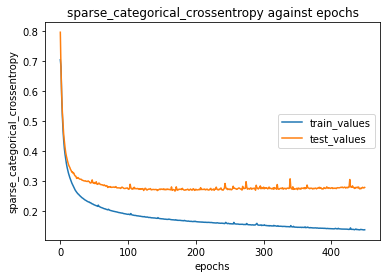

In [39]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name][history_object], label=model_name)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> ```num_neurons=10``` is the optimal number of neurons to use

It has the best performance

> use ```num_neurons=10``` for subsequent notebooks